<a href="https://colab.research.google.com/github/saruman18/GermaParlTEI/blob/main/Party_Classification_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment the following lines if you are working with Collab in our drive
#drive.mount('/content/drive')
#gdrive_path='/content/drive/MyDrive/DeepGroup'
#os.chdir(gdrive_path)
#print(sorted(os.listdir()))

In [ ]:
#For macbook
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

device = torch.device("mps")

True
True


In [ ]:
torch.mps.empty_cache()

In [ ]:
# import libraries
import pandas as pd
from collections import Counter
import numpy as np
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
#Load the data, specifiy the correct file name.
embeddings = torch.load("sample_2018_10000.pth", map_location=torch.device('cpu'))

# Embeddings dataset  

In [ ]:
print(embeddings)

In [ ]:
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings):
        self.labels_with_embeddings = embeddings
        self.embeddings = self.labels_with_embeddings["embeddings"]
        self.labels = self.labels_with_embeddings["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        embedding = self.embeddings[index]
        label = self.labels[index]

        return embedding, label

In [ ]:
embeddeddata = EmbeddingsDataset(embeddings)

In [ ]:
print(len(embeddeddata))

9996



# Split datasets and call dataloader



In [ ]:
# Split the DataFrame into train, validation, and test sets
train_data, temp_data = train_test_split(embeddeddata, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
print("number of training samples: {}".format(len(train_data)))
print("number of validation samples: {}".format(len(val_data)))
print("number of test samples: {}".format(len(test_data)))

number of training samples: 7996
number of validation samples: 1000
number of test samples: 1000


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True) #CHANGE BATCH SIZE HERE!!!!
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
#Check legnth of dataloaders
print(len(train_dataloader))
print(len(val_dataloader))

250
32


In [ ]:
for batch_idx, (embedding, label) in enumerate(val_dataloader):
    if batch_idx >= 5:
        break

    print(f"Batch {batch_idx + 1}:")
    print("Embeddings:")
    print(embedding.shape)  # Print the shape of embeddings tensor
    print("Labels:")
    print(label)  # Print the labels (assuming they're not one-hot encoded)
    print("-" * 50)


Batch 1:
Embeddings:
torch.Size([32, 512, 768])
Labels:
tensor([2, 4, 3, 3, 5, 5, 1, 4, 3, 4, 1, 0, 5, 1, 1, 3, 2, 5, 5, 3, 5, 5, 2, 5,
        0, 2, 3, 1, 4, 1, 5, 3])
--------------------------------------------------
Batch 2:
Embeddings:
torch.Size([32, 512, 768])
Labels:
tensor([5, 4, 0, 4, 5, 1, 5, 1, 0, 3, 1, 0, 5, 4, 0, 4, 1, 3, 2, 2, 3, 3, 2, 1,
        5, 1, 0, 3, 2, 2, 5, 4])
--------------------------------------------------
Batch 3:
Embeddings:
torch.Size([32, 512, 768])
Labels:
tensor([4, 4, 0, 2, 1, 0, 3, 3, 0, 0, 4, 2, 2, 0, 3, 0, 3, 2, 5, 4, 1, 3, 3, 5,
        5, 5, 3, 4, 0, 3, 0, 2])
--------------------------------------------------
Batch 4:
Embeddings:
torch.Size([32, 512, 768])
Labels:
tensor([2, 5, 3, 1, 5, 4, 3, 4, 0, 0, 4, 0, 2, 4, 0, 2, 4, 3, 2, 0, 0, 3, 3, 0,
        5, 2, 5, 5, 0, 1, 0, 0])
--------------------------------------------------
Batch 5:
Embeddings:
torch.Size([32, 512, 768])
Labels:
tensor([4, 2, 5, 3, 4, 3, 3, 1, 3, 5, 4, 0, 3, 1, 0, 4, 1, 4, 3,

# Model

In [ ]:
class Classifier(nn.Module):
    def __init__(self, hp=None):
        super(Classifier, self).__init__()
        self.hp = hp
        self.classifier= nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(hp["input_size"], hp["num_classes"]))

    def forward(self, x):
        logits = self.classifier(x)

        return torch.softmax(logits, dim=1)


# Training Pipeline

In [ ]:
#Set any hyperparameters here in this dict
hparams = {
    "input_size":393216,
    "num_classes": 5, #Adjust number of classes according to the year!
    "lr": 0.00002,
    "epochs":4,
}

In [ ]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, hp = hparams):
    device = torch.device("mps") #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    valid_losses = []

    for epoch in range(hp["epochs"]):
        model.train()
        train_loss = 0

        for embedding, label in train_dataloader:

            embedding = embedding.to(device)
            label= label.to(device)

            #Forward pass.
            party = model(embedding)

            #Compute loss
            loss = criterion(party, label)

            optimizer.zero_grad()

            #Backward pass and optimization
            loss.backward()
            # Update the classifier parameters
            optimizer.step()

            train_loss += loss.item()

        #Calculate avergae training loss
        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()

        with torch.no_grad():
            valid_loss = 0

            for embedding, label in val_dataloader:
                embedding = embedding.to(device)
                label= label.to(device)

                #Forward pass
                party = model(embedding)
                #Compute loss
                loss = criterion(party, label)

                valid_loss += loss.item()

            #Calculate averga validation loss
            valid_loss = valid_loss/ len(val_dataloader.dataset)
            valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1}/{hp['epochs']} - Training loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")

        # Save model parameters at every epoch
        torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')


    print("Finished training")
    return train_losses, valid_losses



In [ ]:
model = Classifier(hp=hparams)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Count the parameters
num_params = count_parameters(model)
print(f"Number of parameters in the model: {num_params}")


Number of parameters in the model: 1966085


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"], betas=([0.9, 0.999]))

criterion = nn.CrossEntropyLoss()

# Training

In [ ]:
train_losses, valid_losses = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, hp = hparams )

In [ ]:
#Plot loss curves
plt.plot(range(1, hparams["epochs"]+1), train_losses, label="Train Loss")
plt.plot(range(1, hparams["epochs"]+1), valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

In [ ]:
#Choose best epoch of the trained model
  #Run this if you have not actively trained a model now, but already have a model file stored somewhere:
  #Create an instance of model
  #model = Classifier(hp=hparams)

# Specify the epoch to load (e.g., for epoch 3)
epoch_to_load = 3
model_state_dict = torch.load(f'model_epoch_{epoch_to_load}.pth')

# Load the model's state_dict
model.load_state_dict(model_state_dict)

model.to(device)
# Now, model contains the parameters from the desired epoch

TypeError: Expected state_dict to be dict-like, got <class '__main__.Classifier'>.

In [ ]:
# Save model
torch.save(model, 'model_2016_final.pth')

In [ ]:
#Reload model if needed, specifiy correct model file name!
model = torch.load('model_2018_final.pth')

# Testing the Model

In [ ]:
def evaluate_model(model, test_dataloader, hp= None):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for embedding, label in test_dataloader:
            embedding = embedding.to(device)
            label = label.to(device)

            # Forward pass
            prediction = model(embedding)
            predicted_label = torch.argmax(prediction, dim=1)

            # Count correct predictions
            correct_predictions += (predicted_label == label).sum().item()
            total_samples += label.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
test_accuracy = evaluate_model(model, test_dataloader, hp=hparams)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.2900


In [ ]:
def evaluate_model_per_class(model, test_dataloader, hp= hparams):
    model.eval()
    correct_per_class = [0] * hp["num_classes"]
    total_per_class = [0] * hp["num_classes"]
    all_predicted_labels = []
    all_true_labels = []

    with torch.no_grad():
        for embedding, label in test_dataloader:
            embedding = embedding.to(device)
            label = label.to(device)

            # Forward pass
            prediction = model(embedding)
            predicted_label = torch.argmax(prediction, dim=1)

            # Update per-class counts
            for i in range(hp["num_classes"]):
                correct_per_class[i] += ((predicted_label == i) & (label == i)).sum().item()
                total_per_class[i] += (label == i).sum().item()

            # Append predicted and true labels to lists
            all_predicted_labels.extend(predicted_label.cpu().numpy())
            all_true_labels.extend(label.cpu().numpy())

    accuracy_per_class = [correct / total if total > 0 else 0 for correct, total in zip(correct_per_class, total_per_class)]
    return accuracy_per_class, all_predicted_labels, all_true_labels


In [ ]:
accuracy_per_class, all_predicted_labels, all_true_labels = evaluate_model_per_class(model, test_dataloader, hp= hparams)

In [ ]:
# Define the party_to_labels dictionary
#Adapt the dictionary according to the years!
party_to_labels =  {'SPD': 0, 'CDU/CSU': 1, 'AfD': 2, 'DIE LINKE': 3, 'FDP': 4, 'GRUENE': 5} #2018

#{'CDU/CSU': 0, 'SPD': 1, 'DIE LINKE': 2, 'FDP': 3, 'GRUENE': 4} #2012
#{'CDU/CSU': 0, 'DIE LINKE': 1, 'GRUENE': 2, 'SPD': 3} #2014
#{'CDU/CSU': 0, 'DIE LINKE': 1, 'SPD': 2, 'GRUENE': 3} #2016
#{'SPD': 0, 'AfD': 1, 'CDU/CSU': 2, 'FDP': 3, 'DIE LINKE': 4, 'GRUENE': 5} #2020

# Print accuracies for each class
for class_idx, accuracy in enumerate(accuracy_per_class):
    # Find the label for the current class index
    label = None
    for party, idx in party_to_labels.items():
        if idx == class_idx:
            label = party
            break

    if label is not None:
        print(f"Accuracy for Class {label}: {accuracy:.4f}")
    else:
        print(f"Accuracy for Class {class_idx}: {accuracy:.4f}")


Accuracy for Class SPD: 0.1043
Accuracy for Class CDU/CSU: 0.3416
Accuracy for Class AfD: 0.3614
Accuracy for Class DIE LINKE: 0.2849
Accuracy for Class FDP: 0.2184
Accuracy for Class GRUENE: 0.4395


In [ ]:
# Use predictions and true labels from above
predictions = np.array(all_predicted_labels)
true_labels = np.array(all_true_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, normalize='true')

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[0.10429448 0.3006135  0.0797546  0.14723926 0.14110429 0.22699387]
 [0.08074534 0.34161491 0.13664596 0.08074534 0.13664596 0.22360248]
 [0.05421687 0.10843373 0.36144578 0.1626506  0.14457831 0.1686747 ]
 [0.05027933 0.10614525 0.17318436 0.2849162  0.10614525 0.27932961]
 [0.05747126 0.21264368 0.14367816 0.12068966 0.2183908  0.24712644]
 [0.06369427 0.10191083 0.12101911 0.12738854 0.14649682 0.43949045]]


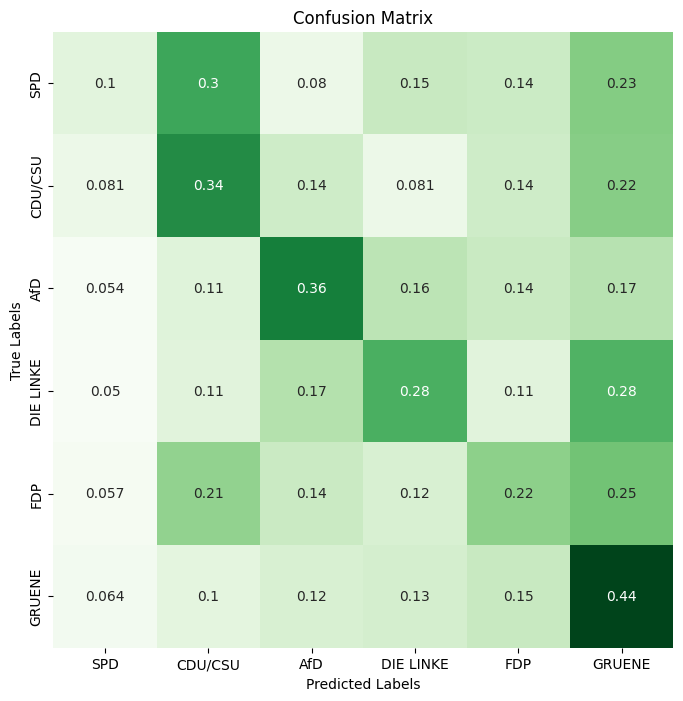

In [ ]:
# Create a heatmap of the confusion matrix
class_labels = [party for party, label in sorted(party_to_labels.items(), key=lambda x: x[1])]

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.2891
Recall: 0.2900
F1 Score: 0.2802
